### Przygotowanie danych

In [1]:
# Import bibliotek
import numpy as np

import random
import pandas as pd

from sklearn.model_selection import train_test_split
from livelossplot import PlotLossesKeras
from livelossplot.keras import PlotLossesCallback
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPool2D, Lambda
import keras
#!pip install livelossplot
from livelossplot import PlotLossesKeras
from livelossplot.keras import PlotLossesCallback
from PIL import Image
from os import listdir
from os.path import splitext


In [7]:
# Wczytanie tensorów X i y
X = np.load('X_multi.npy')
y = np.load('y_multi.npy')

print(X.shape, y.shape)

(5975, 128, 128, 3) (5975,)


In [8]:
# Podział danych X i y na zbiór treningowy i walidacyjny
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=2019)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(4780, 128, 128, 3) (4780,)
(1195, 128, 128, 3) (1195,)


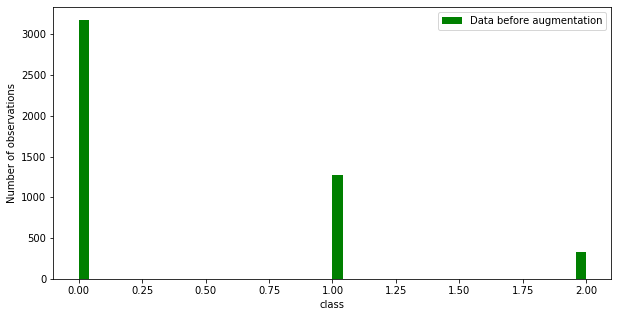

In [9]:
# Porównanie histogramów przed i po augmentacji
plt.figure(figsize=(10,5))
plt.hist(y_train, 50, facecolor='green');
#plt.hist(ygen, 50, facecolor='red');
plt.xlabel('class');
plt.ylabel('Number of observations');
plt.legend(['Data before augmentation']);
plt.show()

In [10]:
print('X_train.shape:',X_train.shape, ' X_test.shape:',X_test.shape)

X_train.shape: (4780, 128, 128, 3)  X_test.shape: (1195, 128, 128, 3)


In [11]:
# Przygotowanie wektora odpowiedzi y (nr klasy do której należy obraz)

#Krok 1. Sprawdzenie wymiaru wektora y
print('y_train.shape:',y_train.shape, 'y_test.shape:',y_test.shape) # wymiar
print('y_train[5]',y_train[5]) # przykładowy wiersz

y_train.shape: (4780,) y_test.shape: (1195,)
y_train[5] 0


In [12]:
#Krok 2. Kategoryzacja danych
# realizacja pętli: jeżeli długość wektora y jest równa 1 to:  skategoryzuj wektory wg numeru klasy
if len(y_train.shape)== 1:
    num_classes = len(set(y_train))
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)

In [13]:
num_classes

3

In [14]:
# Krok 3. Sprawdzenie wymiaru wektora y po edycji
print('y_train.shape:',y_train.shape, 'y_test.shape:',y_test.shape)
print(y_train[5])

y_train.shape: (4780, 3) y_test.shape: (1195, 3)
[1. 0. 0.]


In [15]:
# Rozmiar obrazów:
img_rows, img_cols = X_train.shape[1],X_train.shape[2]
input_shape = (img_rows, img_cols, 3)

print('img_rows:',img_rows, 'img_cols:',img_cols, 'input_shape:', input_shape)

img_rows: 128 img_cols: 128 input_shape: (128, 128, 3)


## Ananliza architektury CNN

# Wariant 1. błąd 30%

In [16]:
#6. Budowa architektury CNN
model = Sequential([
    
    #pierwsza warstwa konwolucyjna: 32 filtry o rozmiarach 3x3 piksele
    Conv2D(filters=32, kernel_size=(3,3),input_shape=input_shape), 
    MaxPool2D(pool_size=(2,2)),
    # do zmniejszenia ilości danych, przegląd każdego kwadratu o wym. 2x2 
    # i zatrzymanie wartości największej z danego kwadratu

    Conv2D(filters=64, kernel_size=(3,3)),
    MaxPool2D(pool_size=(2,2)),
    
    Conv2D(filters=128, kernel_size=(3,3)),
    MaxPool2D(pool_size=(2,2)),
    
    Flatten(), # spłaszcza macierz 2D po filtracjach do wektora
    
    Dense(512,activation='relu'),
    Dense(num_classes,activation='softmax')]) 


In [17]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)            

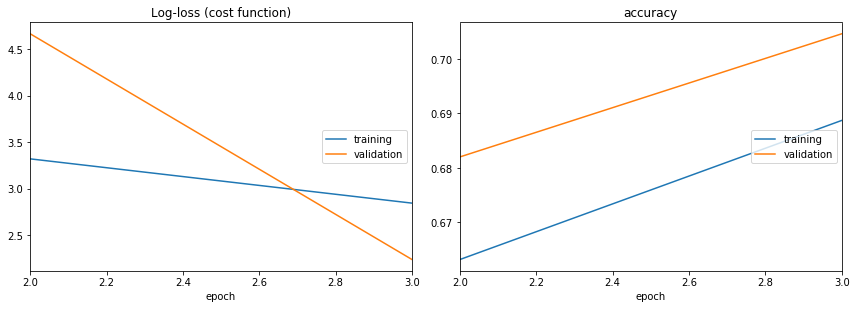

Log-loss (cost function):
training   (min:    2.846, max:  191.851, cur:    2.846)
validation (min:    2.242, max:    7.147, cur:    2.242)

accuracy:
training   (min:    0.564, max:    0.689, cur:    0.689)
validation (min:    0.331, max:    0.705, cur:    0.705)
[2.2416813648894243, 0.7046025395393372]


In [18]:
# Trenowanie modelu:
plot_losses = PlotLossesCallback()

history = model.fit(X_train, y_train,
          batch_size=128,
          epochs=3,
          verbose=1,
          callbacks=[plot_losses],
          validation_data=(X_test, y_test))

score = model.evaluate(X_test, y_test, verbose=0)
print(score)

In [19]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

print("CNN Error: %.2f%%" % (100-score[1]*100))

Test loss: 2.2416813648894243
Test accuracy: 0.7046025395393372
CNN Error: 29.54%


In [20]:
def draw_learning_curve(history, key='accuracy', ylim=(0.8, 1.01)):
    plt.figure(figsize=(12,6))
    plt.plot(history.history[key])
    plt.plot(history.history['val_' + key])
    plt.title('Learning Curve')
    plt.ylabel(key.title())
    plt.xlabel('Epoch')
    plt.ylim(ylim)
    plt.legend(['train', 'test'], loc='best')
    plt.show()

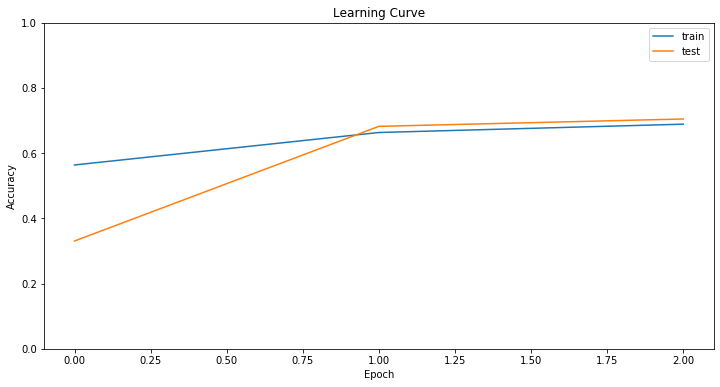

In [21]:
draw_learning_curve(history, key='accuracy', ylim=(0.0, 1.))

## Wariant 2. Błąd: %

In [22]:
def get_doubled_cnn3_nodropout():
    return Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape),
        Conv2D(32, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        
        Flatten(),
        
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])


model = get_doubled_cnn3_nodropout()
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 126, 126, 32)      9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 63, 63, 64)        18496     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 61, 61, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 30, 30, 128)      

In [23]:
import time;

localtime = time.asctime( time.localtime(time.time()) )
print("Local current time :", localtime)

Local current time : Fri Dec 27 12:26:14 2019


In [24]:
time.time()

1577445977.0489829

In [25]:
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [26]:
# Training
plot_losses = PlotLossesCallback()


time_callback = TimeHistory()

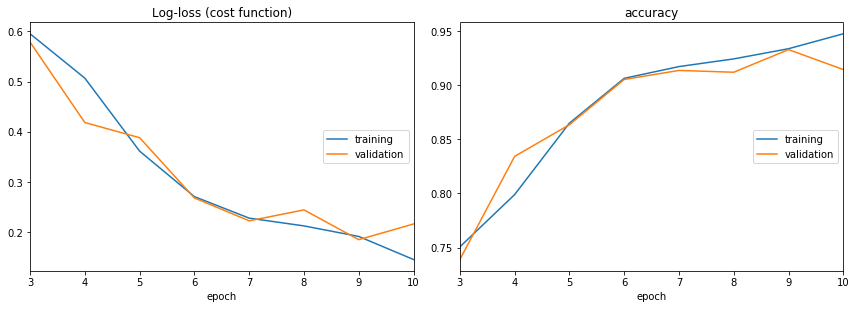

Log-loss (cost function):
training   (min:    0.146, max:    4.477, cur:    0.146)
validation (min:    0.185, max:    0.711, cur:    0.216)

accuracy:
training   (min:    0.618, max:    0.948, cur:    0.948)
validation (min:    0.685, max:    0.933, cur:    0.915)


In [27]:
history = model.fit(X_train, y_train,
          batch_size=128,
          epochs=10,
          verbose=1,
          callbacks=[plot_losses, time_callback],
          validation_data=(X_test, y_test))

In [28]:
times = time_callback.times
print(time_callback.times)

[124.51510953903198, 122.18223237991333, 122.56613111495972, 124.31550097465515, 124.98657393455505, 127.71467566490173, 128.57146883010864, 127.8177592754364, 128.21166920661926, 129.02952313423157]


In [29]:
# Testing
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

print("CNN Error: %.2f%%" % (100-score[1]*100))

Test loss: 0.21630458435254116
Test accuracy: 0.9146443605422974
CNN Error: 8.54%


In [34]:
# Sprawdzenie zbioru randomowych zdjęć
random_test = 'D:/SF/LINIE/PLD_IR_VIS/PLD_VIS/test2/'
base = '.bmp'
filename_tested_list = []
prediction_list = []
class_list=[]


for file in listdir(random_test):
    filename, extension = splitext(file)
    img = np.asarray(Image.open(random_test + file))
    
    img_rows, img_cols = img.shape[0],img.shape[1] #reshape
    img =img.reshape(-1, img_rows, img_cols, 3 )
    
    #predykcja
    t1 = time.time()
    
    predykcja = model.predict(img)
    klasa =predykcja.argmax()
    prediction_list.append(predykcja)
    class_list.append(klasa)
    
    t2 = time.time()
    print( 'Time taken was {} seconds'.format( t2 - t1))
    filename_tested_list.append(random_test + file)

df_tested = pd.DataFrame.from_dict({'path':filename_tested_list})
df_predicted = pd.DataFrame.from_dict({'path':filename_tested_list,'prediction':class_list})

class_list

Time taken was 0.010133743286132812 seconds
Time taken was 0.01017141342163086 seconds
Time taken was 0.009885549545288086 seconds
Time taken was 0.015860319137573242 seconds
Time taken was 0.004020214080810547 seconds
Time taken was 0.009938716888427734 seconds
Time taken was 0.01024770736694336 seconds
Time taken was 0.009922266006469727 seconds
Time taken was 0.009709596633911133 seconds
Time taken was 0.009968042373657227 seconds
Time taken was 0.010387659072875977 seconds
Time taken was 0.009899139404296875 seconds
Time taken was 0.0 seconds
Time taken was 0.009922981262207031 seconds
Time taken was 0.01587986946105957 seconds
Time taken was 0.004021167755126953 seconds
Time taken was 0.010266780853271484 seconds
Time taken was 0.009897232055664062 seconds
Time taken was 0.009920835494995117 seconds
Time taken was 0.0 seconds
Time taken was 0.010187864303588867 seconds
Time taken was 0.009759187698364258 seconds
Time taken was 0.010075807571411133 seconds
Time taken was 0.00982713

[0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]

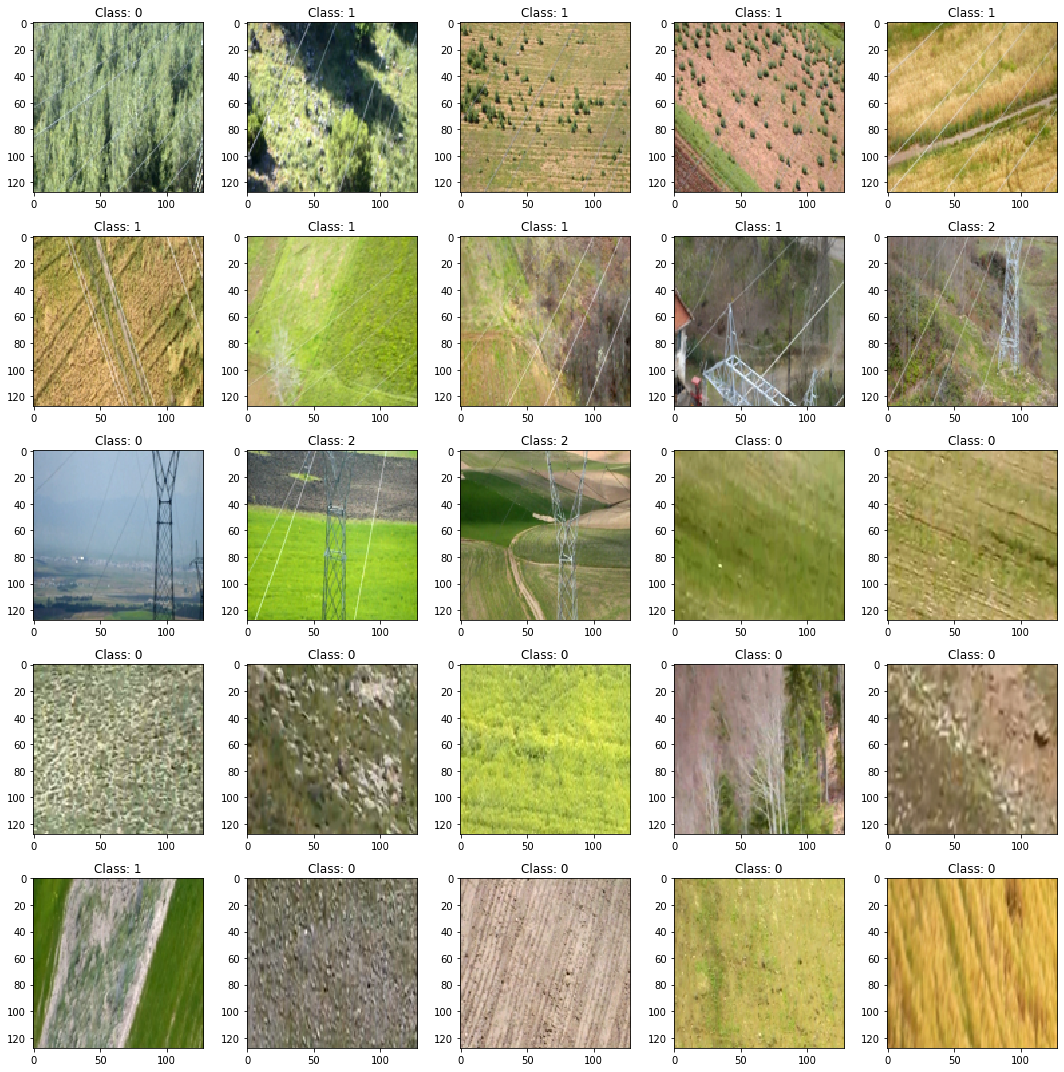

In [35]:
# wizualizacja testowych zdjęć

plt.figure(figsize=(15,15))

nr_img = np.random.randint(10, size=(1, 10))

for idx in range(25): # tu trzeba zrobić żeby nie wpisywać z alca liczby zdjęć w folderze
    plt.subplot(5,5,idx+1)
    img = Image.open(df_tested['path'][idx])
    
    plt.imshow(img)
    plt.title('Class: {}'.format(df_predicted['prediction'][idx]))# wyjściowa klasa 
    
plt.tight_layout()